# Load packages and data

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import collections
import itertools
import seaborn as sns

from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

import toverboom
import toverboom.optimizeLayout
import toverboom.lineageGraph

import random

### Import scar data:

In [2]:
pathToData = '/Users/m.blotenburg/Documents/Projects/Mouse_Scartrace/Data_analysis/Scar_analysis/20200324_VAN2988_remap_BWAfilters-alleleCalling/'
df = pd.read_pickle(pathToData + 'unfiltered_120hAA_dataframeForHeatmap_All.pickle.gz')

In [3]:
df.head()

129, 114682729 129, 114708745 129, 114723869  \
C5A9 A2_1               WT             WT             WT   
     A2_10             NaN            NaN            NaN   
     A2_100            NaN            NaN             WT   
     A2_101            NaN            NaN            NaN   
     A2_102            NaN            NaN            NaN   

                                                129, 114746370  \
C5A9 A2_1                                                   WT   
     A2_10                                                 NaN   
     A2_100                                                NaN   
     A2_101                                                NaN   
     A2_102  114746424.D,114746425.D,114746426.D,114746427....   

                                                129, 114788469  \
C5A9 A2_1                                                   WT   
     A2_10   114788517.D,114788518.D,114788519.D,114788520....   
     A2_100                                        114788524.D   
     A2_101                114788524.D,114788525.D,114788526.D   
     A2_102                                                NaN   

                                                129, 114788470 129, 114788518  \
C5A9 A2_1                                                   WT             WT   
     A2_10   114788517.D,114788518.D,114788519.D,114788520....            NaN   
     A2_100                                        114788524.D            NaN   
     A2_101                114788524.D,114788525.D,114788526.D            NaN   
     A2_102                                                NaN            NaN   

            129, 114788522 129, 114788530 129, 114817194  ...  \
C5A9 A2_1               WT             WT             WT  ...   
     A2_10              WT             WT            NaN  ...   
     A2_100             WT             WT             WT  ...   
     A2_101             WT             WT            NaN  ...   
     A2_102             WT            NaN            NaN  ...   

            nonallelic, 114788529 nonallelic, 114788523 nonallelic, 114788525  \
C5A9 A2_1                     NaN                   NaN                   NaN   
     A2_10                    NaN                   NaN                   NaN   
     A2_100                   NaN                   NaN                   NaN   
     A2_101                   NaN                   NaN                   NaN   
     A2_102                   NaN                   NaN                   NaN   

            nonallelic, 114829471 nonallelic, 114788606 nonallelic, 114704246  \
C5A9 A2_1                     NaN                   NaN                   NaN   
     A2_10                    NaN                   NaN                   NaN   
     A2_100                   NaN                   NaN                   NaN   
     A2_101                   NaN                   NaN                   NaN   
     A2_102                   NaN                   NaN                   NaN   

            nonallelic, 114788620 nonallelic, 114843845 nonallelic, 115243023  \
C5A9 A2_1                     NaN                   NaN                   NaN   
     A2_10                    NaN                   NaN                   NaN   
     A2_100                   NaN                   NaN                   NaN   
     A2_101                   NaN                   NaN                   NaN   
     A2_102                   NaN                   NaN                   NaN   

            nonallelic, 114682796  
C5A9 A2_1                     NaN  
     A2_10                    NaN  
     A2_100                   NaN  
     A2_101                   NaN  
     A2_102                   NaN  

[5 rows x 178 columns]

### Import transcriptome data:

In [4]:
cells_clusters = pd.read_csv('/Users/m.blotenburg/Desktop/scanpy_cells_louvainclusters_colors120hAA.csv')

In [5]:
cells_clusters.head()

,cellname,index,louvain,umap_V1,umap_V2,cellname.1,gastruloid,louvain_colors,germlayer_colors
0,A1_1,A1_1.C5A4,Early endoderm1,0.168446,-3.569604,A1_1,C5A4,orange,blue
1,A1_10,A1_10.C5C3,Early endoderm1,1.129176,-4.579352,A1_10,C5C3,orange,blue
2,A1_100,A1_100.C5C3,Early endoderm2,4.106470,-4.697111,A1_100,C5C3,orange,blue
3,A1_102,A1_102.C5C3,Neurons1,-0.229431,3.547628,A1_102,C5C3,green,green
4,A1_103,A1_103.C5C3,Early endoderm2,2.677049,-3.243759,A1_103,C5C3,orange,blue


# Define pre-scarred regions, definitions for graph construction, tree building, and tree visualisation:

Check the most common scars for a certain allele/site

In [6]:
mostCommonScars = {scar:collections.Counter(df[scar]).most_common(1) for scar in df}

In [7]:
pd.DataFrame(mostCommonScars).T.head()

,0
"129, 114682729","(WT, 38)"
"129, 114708745","(WT, 560)"
"129, 114723869","(WT, 614)"
"129, 114746370","(WT, 620)"
"129, 114788469","(WT, 1038)"


Set a pre-scarred pattern for the gastruloids that are pre-scarred

In [8]:
# Set pre-scar pattern:
pre_scar_pattern = {  
   # 'B6, 114746370':'114746424.D,114746425.D,114746426.D,114746427.D,114746428.D',
    'B6, 114740505':'114740561.D',
    'B6, 114788470':'114788523.D,114788524.D,114788525.D,114788526.D,114788527.D'
 
}


### Definition for graph construction, tree building and tree visualisation:

In [9]:
def makeTree(gastruloid, df = df, cells_clusters = cells_clusters, selectedSites = 0.3, showAllPlots = False, 
             transcriptomeColours = 'louvain_colors'):
    
    ###### First: construct ancestry graph ######
    
    # Select which sites to use for graph construction, sites need to be covered by at least n% cells (standard: 0.3 - 30%)
    selection = df.loc[gastruloid,pd.notnull(df.loc[gastruloid]).sum() / collections.Counter([gastruloids for gastruloids, cell in df.index])[gastruloid] >= selectedSites] #[ list(pre_scar_pattern.keys())+['129, 114746370','129, 114682729']]
    
    #construct graph
    ancestry_graph = nx.DiGraph()
    
    for cell_name,row in selection.iterrows():
        state_node = {
        site:scar for site, scar in row.iteritems() if not 'nonallelic' in site
        }
        scar_vector = tuple( str(scar) for site, scar in row.iteritems() if not 'nonallelic' in site )

        if scar_vector in ancestry_graph: # was already added
            ancestry_graph.node[scar_vector]['seen'] += 1
            ancestry_graph.node[scar_vector]['associated_cells'].append(cell_name)
        else:
            ancestry_graph.add_node(
                scar_vector,
                seen = 1,
                associated_cells=[cell_name],
                site_data=state_node
            )
                   
    # Filter nodes for seen > param
    remove = []
    for node in ancestry_graph:
        if ancestry_graph.node[node]['seen'] <= 1 and node.count('nan')>0:
            remove.append(node)
    ancestry_graph.remove_nodes_from(remove)

    scar_vector_order = list(selection.columns)

    # Add wildtype node:
    state_node = {
        site:pre_scar_pattern.get(site,'WT') for site, scar in row.iteritems() if not 'nonallelic' in site
    }

    root_node = tuple( pre_scar_pattern.get(site,'WT') for site, scar in row.iteritems() if not 'nonallelic' in site )
    
    ancestry_graph.add_node(
        root_node,
        seen = 0,
        associated_cells=[],
        site_data=state_node,
        is_root=True   
        )

    def is_null(value):
        if pd.isnull(value):
            return True
        return value=='nan'

    def is_wt(value):
        return value=='WT' and not is_null(value)

    def is_scar(value):
        return not is_null(value) and not is_wt(value)

    def scar_distance(from_scar, to_scar, ancestry_graph, root_node ):
        # It is no allowed to enter the root node from another state
            # Check if we go from a WT site to a scar
        if to_scar == root_node:
            return None
        
        #print(f'{from_scar} > {to_scar}')
        distance = 0
        for site, from_scar_state in ancestry_graph.node[from_scar]['site_data'].items():
            to_scar_state = ancestry_graph.node[to_scar]['site_data'][site]
        
            increment = 0
            if  is_wt(from_scar_state) and is_wt(to_scar_state):
                 increment = 0 # no cost from WT to WT
            
            elif  is_scar(from_scar_state) and is_scar(to_scar_state) and to_scar_state==from_scar_state:
                increment = 0 # no cost from SCAR to SCAR if they are identical
            
            elif is_wt(from_scar_state) and is_scar(to_scar_state):
                increment = 1
            
            # Check if we go from scar to WT.. that is impossible
            elif is_scar(from_scar_state) and is_wt(to_scar_state):
                increment = None

            # Check if the from_scar is a subset of the to_scar:
            else:
                # Allow to go from non-na to na 
                if  not is_null(from_scar_state)  and is_null(to_scar_state) :
                    increment =1
                else:
                    increment = None
                #if set(from_scar_state.split(',') ).issubset(  set(to_scar_state.split(',') )):
                #    distance+=1.5
            #print(f'\t{site} {from_scar_state}->{to_scar_state} = {increment}')
        
            if increment is None:
                return None
            distance += increment
        
        return distance    
    
    for from_scar, to_scar in itertools.product(ancestry_graph.node, repeat=2) :
        # Calculate distance between two nodes:
        distance = scar_distance(from_scar, to_scar, ancestry_graph, root_node=root_node )
        if distance is None:
            #print(f"Not making edge between root_node and {from_scar}")
            pass
        else:
            ancestry_graph.add_edge(from_scar,to_scar, distance=distance)
            ancestry_graph.add_edge(from_scar,to_scar, weight= distance)
        
    for from_node,to_node in ancestry_graph.edges():
        if to_node==root_node:
            print(from_node, to_node)
    
    pos = nx.spring_layout(ancestry_graph)
    
    if showAllPlots == True:
        fig, ax = plt.subplots()
        nx.draw_networkx(ancestry_graph, pos)
        plt.show()
    
    
    ###### Then: construct spanning_arb ######
    
    
    spanning_arb = nx.algorithms.tree.branchings.Edmonds( ancestry_graph ).find_optimum(
        style='arborescence', 
        kind='min',
        default=0,
          preserve_attrs=True
    )

    # Manually copy attributes:
    for node in spanning_arb:
        spanning_arb.node[node].update( ancestry_graph.node[node] )
        
    # Now copy all only nan changes into their parent..
    changed=True
    while changed:
        changed=False
        for node in spanning_arb:
            if nx.degree(spanning_arb, node)==0:
                continue
            if len( list(spanning_arb.successors(node)) )==0:
                # we are inside a leaf:
                #comapre ourself to parent:
                parent = list(spanning_arb.predecessors(node))[0]
                # check if distance is caused by nan
                if not any( list( not( (a==b) or  (is_null(a) or is_null(b)) ) for a,b in  zip(parent,node) ) ):
                    # we should merge to parent:
                    spanning_arb.node[parent]['associated_cells'] += spanning_arb.node[node]['associated_cells']
                    spanning_arb.node[parent]['seen'] += spanning_arb.node[node]['seen']
                    spanning_arb.remove_node(node)
                    changed=True
                    break
    
    pos = nx.spring_layout(spanning_arb)
    
    #spanning_arb.node[list(spanning_arb)[0]]
   
    if showAllPlots == True:
        fig, ax = plt.subplots()
        nx.draw_networkx(spanning_arb, pos)
        plt.show()
    
    
    ###### Then: clean up graph ######
    
    def format_node_name(node):
        return '_'.join(node)

    clean_graph = nx.DiGraph()
    for node in spanning_arb:
        sites_modified = {
            'AAP'+str(site).replace(', ','X'):str(scar)
            for site,scar in ancestry_graph.node[node]['site_data'].items()
            if not is_null(scar)    
        }
        
        clean_graph.add_node(format_node_name(node), 
                             associatedCells ='_'.join( ancestry_graph.node[node]['associated_cells'] ),  
                             totalCells = ancestry_graph.node[node]['seen'],
                             changes=format_node_name(node).count('.'),
                             wildTypes=format_node_name(node).count('WT'),
                             nans=format_node_name(node).count('nan'),
                             isRoot=ancestry_graph.node[node].get('is_root',False),
                                **sites_modified
                            )

    for a,b in spanning_arb.edges():
        clean_graph.add_edge(
            format_node_name(a),
            format_node_name(b),  
            scarDistance=ancestry_graph[a][b]['distance'])

    #nx.write_gml(clean_graph,'scar_graph.gml')
    

    ###### Then: create expanded graph ######
    
    # Create pseudo timepoint expansion

    # detect depth of tree (max len path) + 1
    pseudo_timepoint_len = len( nx.algorithms.dag.dag_longest_path(spanning_arb, weight='NONE') ) + 1

    expanded_graph = nx.DiGraph()
    expanded_graph.add_node( (root_node,0), 
                            radius=1, first_tp = 0,
                            **ancestry_graph.node[root_node] )

    for node in spanning_arb:
        # the first pseudotimepoint of the node is at the distance to the root 
        try:
            if node == root_node:
                first_tp = 0
            else:
                first_tp = nx.shortest_path_length( spanning_arb, root_node, node )
            prev = None
            # expand the node to every timepoint until the end of pseudotime:
            for tp in range(first_tp,pseudo_timepoint_len):
                expanded_graph.add_node( (node,tp), 
                                        radius=ancestry_graph.node[node]['seen'], first_tp = first_tp,
                                        **ancestry_graph.node[node] )
                spanning_arb.node[node]['first_tp'] = first_tp
                if prev is not None:
                    expanded_graph.add_edge( prev, (node,tp) )
                prev = (node,tp) 
        except nx.NetworkXNoPath:
            continue
    # Now create inter-clone edges:
    for from_node, to_node in spanning_arb.edges():
        to_tp = spanning_arb.node[to_node]['first_tp']
        from_tp = to_tp - 1
        expanded_graph.add_edge((from_node,from_tp) , (to_node,to_tp))
         
    # same layout using matplotlib with no labels
    pos = graphviz_layout(expanded_graph, prog='dot')

    if showAllPlots == True:
        fig, ax = plt.subplots()
        nx.draw_networkx(expanded_graph, pos)
        plt.show()

    expanded_graph[root_node,0]

    expanded_graph = nx.algorithms.tree.branchings.Edmonds( expanded_graph ).find_optimum(
        style='arborescence', 
        kind='min',
        preserve_attrs=True,
        default=0,
    )
    
# Copy attributes because preserve_attrs is not working
    for node,tp in expanded_graph:
        expanded_graph.node[node,tp]['radius'] = ancestry_graph.node[node]['seen']
    
    # same layout using matplotlib with no labels
    pos = graphviz_layout(expanded_graph, prog='dot')

    initial_order = [(state) for state, tp in pd.DataFrame(pos).T.sort_values(0).index]
    seen = set()
    initial_order = [x for x in initial_order if (x not in seen) and not seen.add(x)]

    #expanded_graph.node[list(expanded_graph)[1]]
 

    ###### Create toverboom topology ######
    
    # Instantiate the lineage graph object
    lg = toverboom.lineageGraph.LineageGraph(expanded_graph)

    for node in lg.graph:
        if len(list(lg.graph.successors(node)))==0:
            lg.graph.node[node]['leaf'] = True
        else:
            lg.graph.node[node]['leaf'] = False

    # Create a figure for our plot:
    fig, ax = plt.subplots()

    # Find the best layout
    toverboom.optimizeLayout.optimize_layout(lg,
                                             visualize_progress_ax=ax, 
                                             visualize_progress_fig=fig,
                                             #initial_order=initial_order ,no_optim=True     
                                            )
    pass


    ###### Make dataframe that is used as input for tree visualisation ######
    
    cellDataDict = collections.defaultdict(dict)
    for clone,tp in lg.graph:
        if tp==(pseudo_timepoint_len-1):
            lg.graph.node[(clone,tp)]['radius'] = len(ancestry_graph.node[clone]['associated_cells'])
        
            for cell in ancestry_graph.node[clone]['associated_cells']:
                cellDataDict[(clone,tp,cell)] = {'tp':tp, 'cluster':clone}
    
    cellData = pd.DataFrame(cellDataDict).T
    
    
    ###### Couple scar dataframe to transcriptome dataframe ######    
    
    cellData2 = cellData.copy()
    index = cellData2.reset_index()
    index['cellname'] = index['level_2']

    cellData2 = index.merge(cells_clusters, on = 'cellname')
    cellData2 = cellData2.set_index(['level_0','level_1','level_2'])

    def scale(coordinates,pc = 10):
        start = np.percentile(coordinates,pc) 
        end = np.percentile(coordinates,100-pc)
        return np.interp(coordinates, (start, end), (0.4, 1))

    cellData2['x']  = scale(cellData2['umap_V1'].fillna(0))
    cellData2['y'] = scale(cellData2['umap_V2'].fillna(0))

    
###### MAKE TREE #######

    cells = list(cellData.index)

    # define scar colors:
    cmap = plt.get_cmap('hsv')
    totalScars = set()
    for clone in ancestry_graph:
        for scar in clone:
            totalScars.add(scar)

    totalScars = sorted(list(totalScars))

    random.seed(3.1415927)
    random.shuffle(totalScars)

    scarColors = { scar: cmap(x) for scar, x in zip(totalScars, np.linspace(0,1, len(totalScars))) }
    scarColors.update({'WT':(0,0,0),'nan':'#999999'})

    cellData2['x']-=1
    
    cellData2['size']= 15

    # Plot the polygons of the tree
    fig, ax = plt.subplots()

    # wavyness controls how wavy the segments of the tree are 
    wavyness=0.7
    # xDistance controls the stretch in the x direction 
    lg.xDistance= 10
    lg.verticalSpacing = 2

    lg.setRadiusAttributes(radiusAttribute='radius', 
                           defaultRadius=1, 
                           radiusMultiplier=0.2 )

    lg.plotEdges(ax, bezier=True,wavyness=wavyness,stepCount=30,plotArgs={'linewidth':0}, offsetCentroid=True)
    lg.plotPatches(ax=ax,wavyness=wavyness)

    # Remove plot spines:
    toverboom.lineageGraph.despine(ax)
    # Scale labels to plot size:
    toverboom.lineageGraph.format_x_axis_labels(ax)

    # Add labels to the clones:


    allClones = set([ cluster for cluster,tp in lg.graph ]) - set([0])
    bigClones = set([1,4,2,3,5])

    #cellData = cellCnvBarcode
    #cellData['tp'] = [passage for passage, plate, cell in list(cellData.index)]

    # Remove plot spines:
    toverboom.lineageGraph.despine(ax)

    # Scale labels to plot size:
    toverboom.lineageGraph.format_x_axis_labels(ax)

    # Add vertical lines to indicate sampled timepoints
    lg.plot_xticks(ax, [x for x in cellData2['tp'].unique()])
    lg.plot_vertical_lines(ax, cellData2['tp'].unique(), c='k')

    lg.plotSingleCells(ax=ax, cellData = cellData2,fig=fig, cellJitter = 4,
                       colorAttribute = transcriptomeColours,yOffsetAttribute='y',xOffsetAttribute='x',
                       yJitterRatio=2,defaultXOffset = 50,defaultYOffset = 50,
                       defaultLinewidth = 0.5)
    

    ax.set_xlabel('Pseudotime')

    x_start = lg.getXCoordinate(pseudo_timepoint_len) - 8
    rect_size = 4

    #lg.annotateNodes(ax=ax)

    maxY = max([y for clone,y in lg.getTrellisCoordinates().items()])
    for clone, y in lg.getTrellisCoordinates().items():
    
        for i,scar in enumerate(clone):
            x = x_start + (rect_size*i)
            if y ==  maxY:
                # show label of scar:
                ax.text( x+0.5*rect_size,y+5, scar_vector_order[i], ha='center',va='bottom', rotation=90, size='smaller')
            node_height = max(2,lg.getNodeRadius( node=(clone,pseudo_timepoint_len-1) )*2)
        
            ax.add_patch(
                matplotlib.patches.Rectangle((x, y-node_height*0.5), 
                                             rect_size,node_height,
                                             fc=scarColors.get(scar,'r')
                                            ),
        
            )

    ax.get_yaxis().set_visible(False) 
    ax.set_xticklabels('')
    ax.set_xlabel('Pseudotime')
    ax.set_xlim(0, x_start + (rect_size*(i+2))) 
    ax.set_ylim(0,maxY+24) 

    fig.canvas.draw()
#
#plt.savefig('/Users/m.blotenburg/Desktop/120hAA_C5H11.png', dpi=500)
    

# Determine which gastruloids are present in the data and run the tree building for each gastruloid

Check the amount of cells for each gastruloid

In [10]:
collections.Counter([gastruloid for gastruloid, cell in df.index]) #groupby('')

Counter({'C5A9': 253,
         'C5B10': 345,
         'C5C6': 315,
         'C5F10': 366,
         'C5G7': 514,
         'C5H11': 480,
         'C5H7': 352,
         'C5H9': 330})

Build trees

In [ ]:
makeTree('C5A9')

In [ ]:
makeTree('C5B10')

In [ ]:
makeTree('C5C6')

<IPython.core.display.Javascript object>


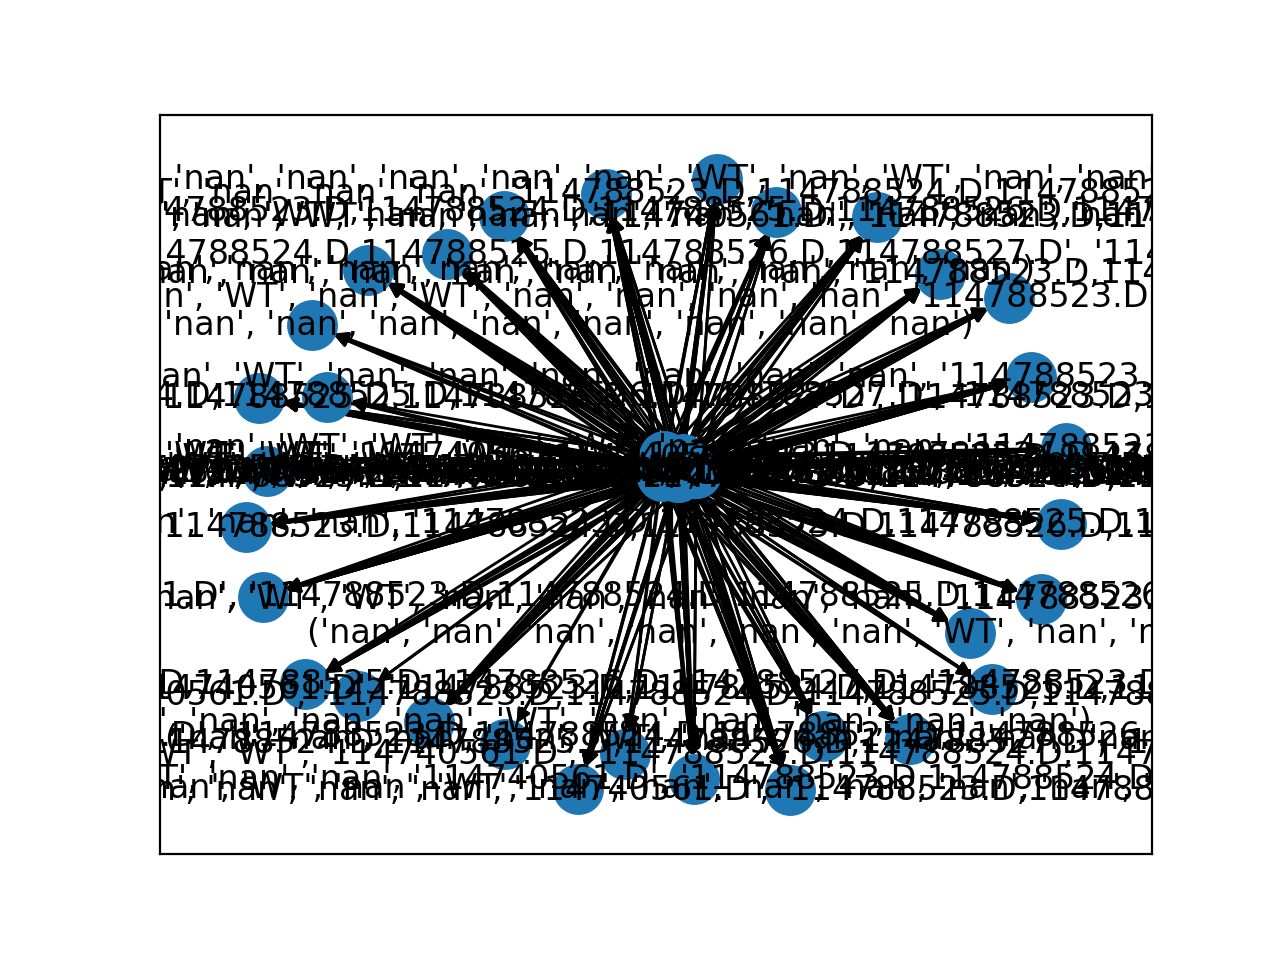

<IPython.core.display.Javascript object>


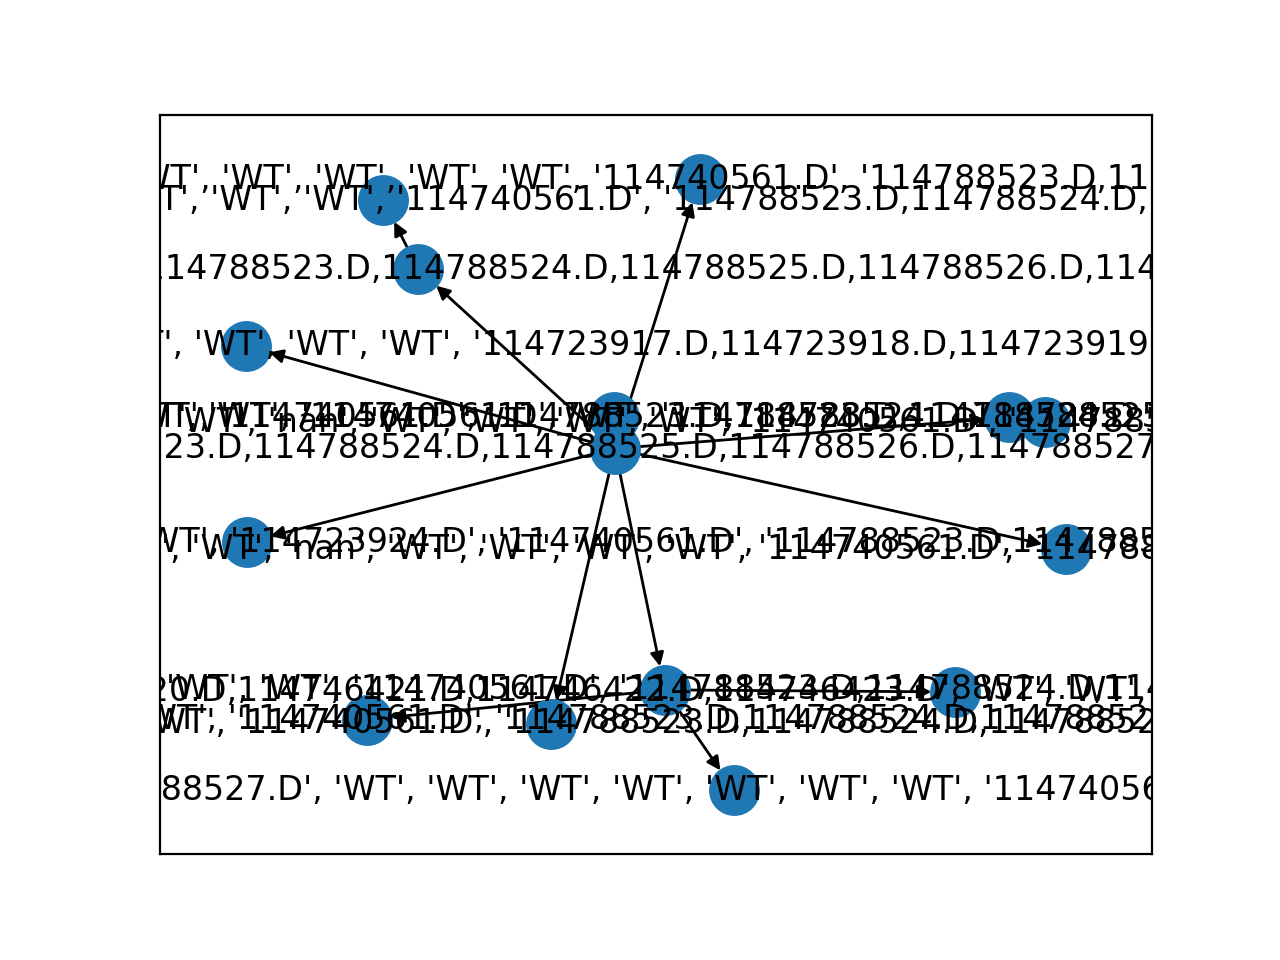

<IPython.core.display.Javascript object>


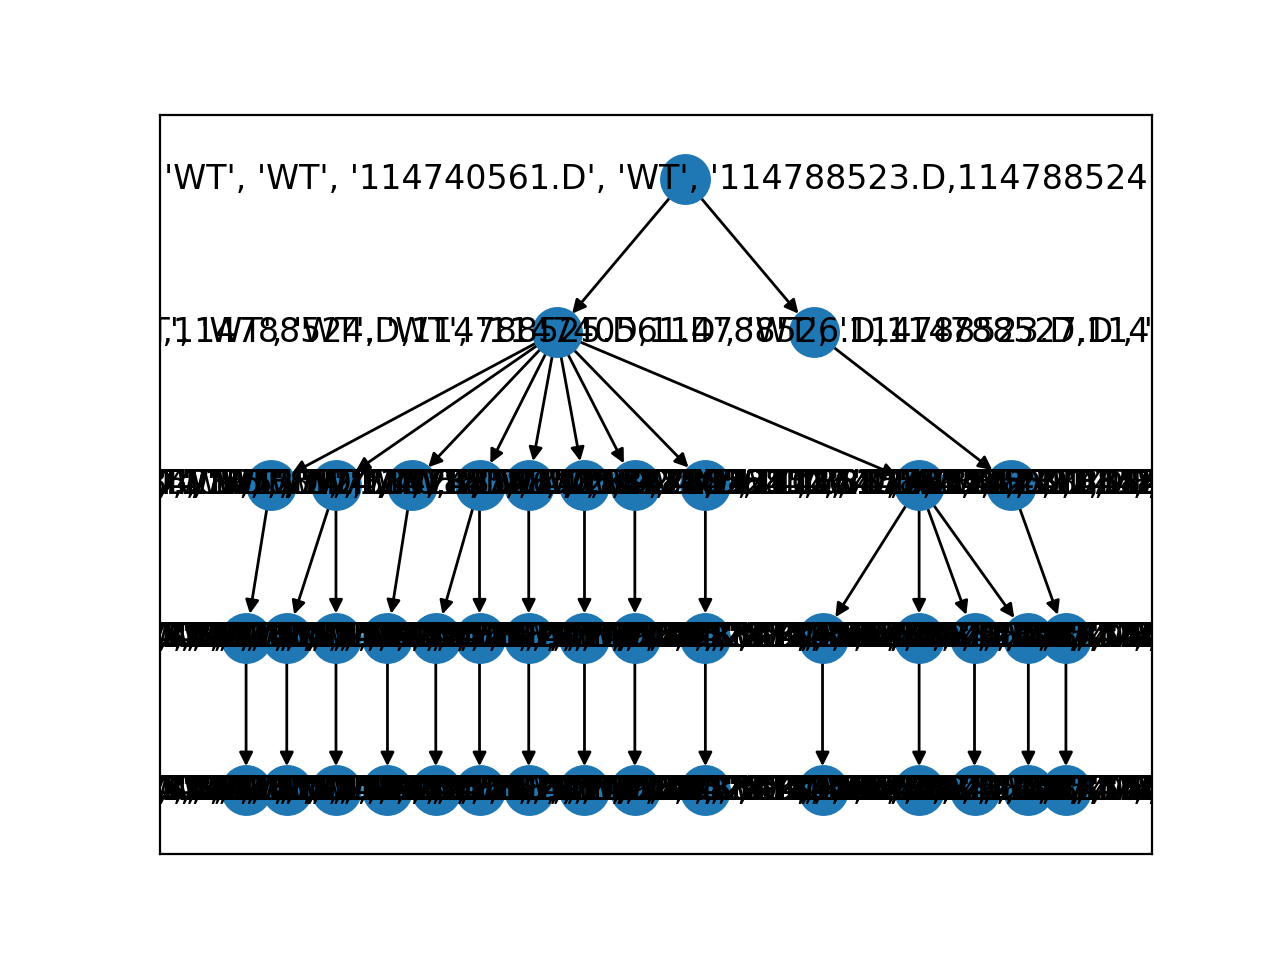

<IPython.core.display.Javascript object>


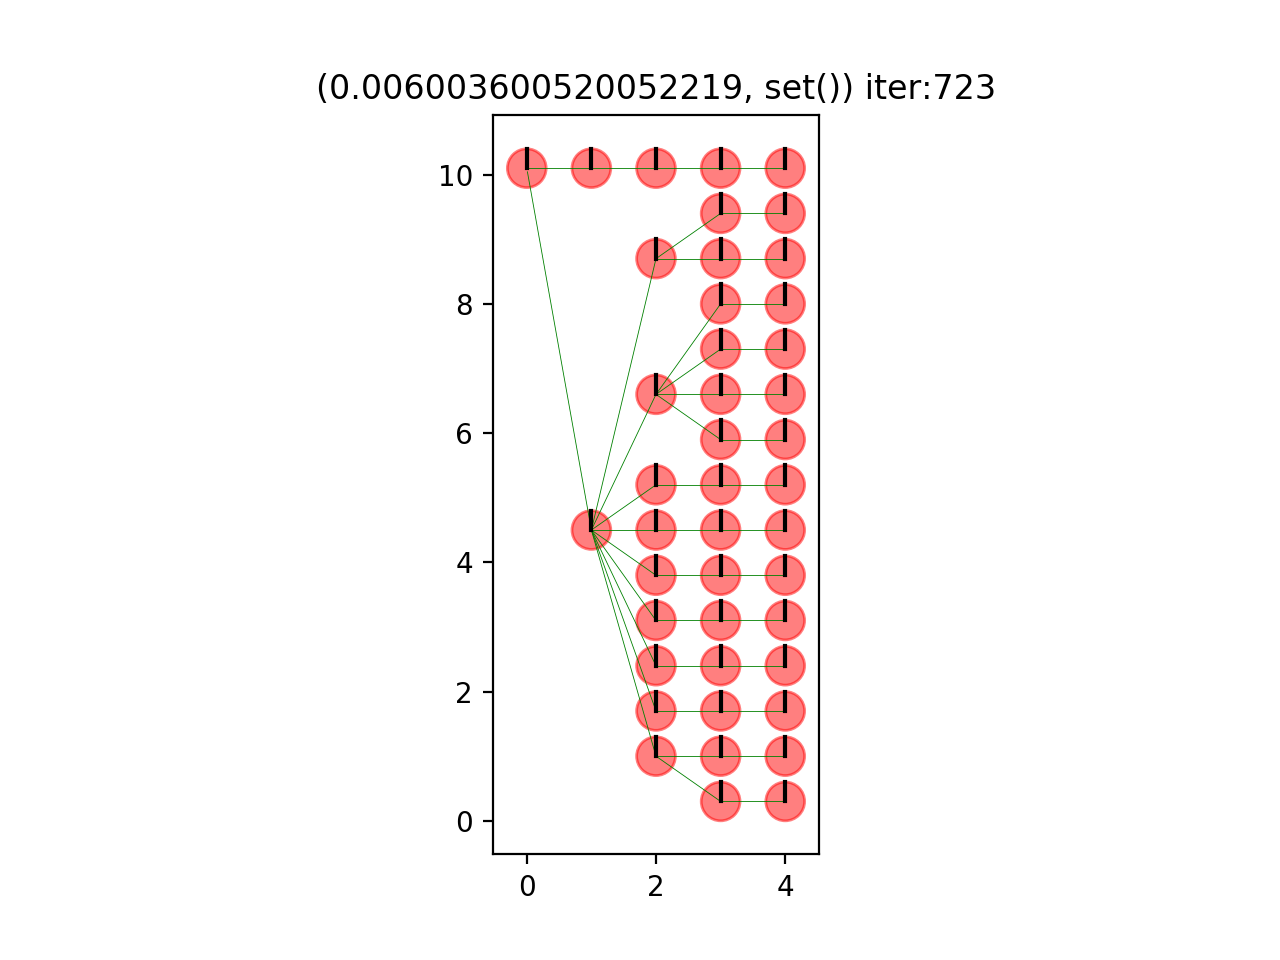

<IPython.core.display.Javascript object>


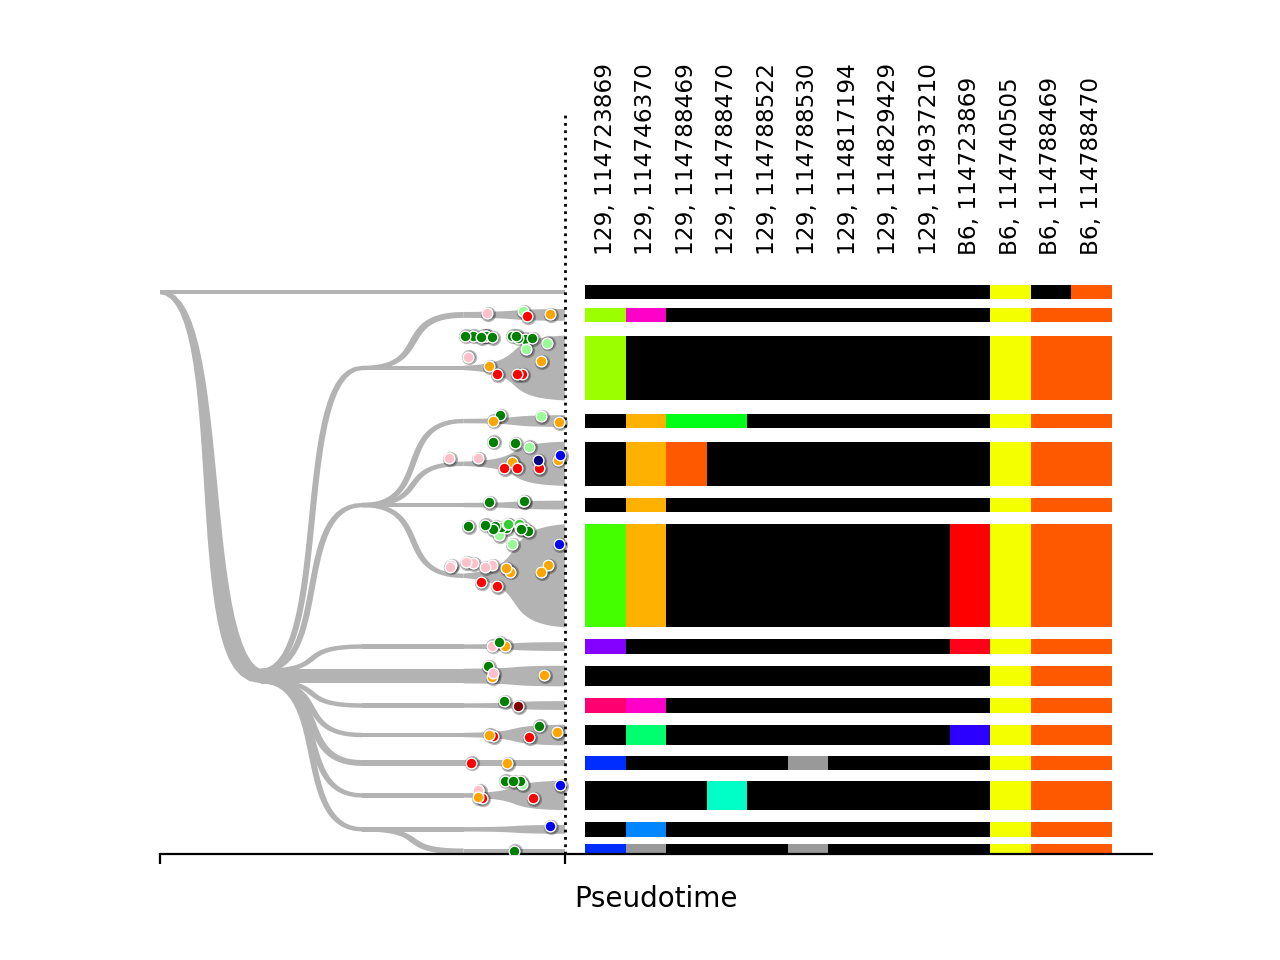

In [11]:
makeTree('C5F10', showAllPlots=True)

In [ ]:
makeTree('C5G7')

In [ ]:
makeTree('C5H11')

In [ ]:
makeTree('C5H7')

In [ ]:
makeTree('C5H9')

In [ ]:
makeTree('C5F10', transcriptomeColours='germlayer_colors', showAllPlots = False)